In [1]:
import os
os.chdir("/home/smarpaka/hackday-q2-2024-open-earth-foundation")

import censusdis.data as ced
import censusdis.maps as cem
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from censusdis.states import ALL_STATES_AND_DC
from src.utils import *

/nas/local/simscripts/smarpaka/.nest/2024-q2-dc/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# Get all BTS Trips data
bts_data = load_data_from_ts3("BTS Trips/Trips_by_Distance_20240523.csv")
bts_data = bts_data[["Date", "State FIPS", "State Postal Code", "County FIPS", "County Name", "Population Staying at Home", "Population Not Staying at Home", "Number of Trips"]]
bts_data

Date  State FIPS State Postal Code  County FIPS County Name  \
Level                                                                         
National  2019/01/01         NaN               NaN          NaN         NaN   
National  2019/01/02         NaN               NaN          NaN         NaN   
National  2019/01/03         NaN               NaN          NaN         NaN   
National  2019/01/04         NaN               NaN          NaN         NaN   
National  2019/01/05         NaN               NaN          NaN         NaN   
...              ...         ...               ...          ...         ...   
State     2024/01/20        10.0                DE          NaN         NaN   
State     2024/01/20        23.0                ME          NaN         NaN   
State     2024/01/20        40.0                OK          NaN         NaN   
State     2024/01/20        55.0                WI          NaN         NaN   
State     2024/01/20        54.0                WV          NaN         NaN   

          Population Staying at Home  Population Not Staying at Home  \
Level                                                                  
National                  77433867.0                     248733553.0   
National                  61305201.0                     264862219.0   
National                  63050480.0                     263116940.0   
National                  61803652.0                     264363768.0   
National                  64389745.0                     261777675.0   
...                              ...                             ...   
State                       206202.0                        767562.0   
State                       266826.0                       1077386.0   
State                       838696.0                       3118275.0   
State                      1132189.0                       4690245.0   
State                       386799.0                       1405348.0   

          Number of Trips  
Level                      
National     8.977844e+08  
National     1.139452e+09  
National     1.162753e+09  
National     1.181954e+09  
National     1.180477e+09  
...                   ...  
State        4.018660e+06  
State        6.290102e+06  
State        1.590454e+07  
State        2.697016e+07  
State        7.236616e+06  

[6142062 rows x 8 columns]

In [3]:
# For 'County' level data, add 'Total Population' + 'Per Capita' columns
bts_enhanced = bts_data.copy()
bts_enhanced = bts_enhanced.query("Level == 'County'")
bts_enhanced["County FIPS"] = bts_enhanced['County FIPS'].astype(int).astype(str).str.zfill(5)
bts_enhanced["Total Population"] = bts_enhanced[["Population Staying at Home", "Population Not Staying at Home"]].sum(axis=1)
bts_enhanced["Per Capita"] = bts_enhanced["Number of Trips"]/bts_enhanced["Total Population"]
bts_enhanced = bts_enhanced.drop(columns=["Population Staying at Home", "Population Not Staying at Home"])
bts_enhanced

Date  State FIPS State Postal Code County FIPS      County Name  \
Level                                                                           
County  2021/06/06        56.0                WY       56045    Weston County   
County  2021/06/06         5.0                AR       05011   Bradley County   
County  2021/06/06         5.0                AR       05013   Calhoun County   
County  2021/06/06         5.0                AR       05015   Carroll County   
County  2021/06/06         5.0                AR       05017    Chicot County   
...            ...         ...               ...         ...              ...   
County  2024/01/20         1.0                AL       01105     Perry County   
County  2024/01/20         1.0                AL       01107   Pickens County   
County  2024/01/20         1.0                AL       01109      Pike County   
County  2024/01/20         1.0                AL       01111  Randolph County   
County  2024/01/20         1.0                AL       01113   Russell County   

        Number of Trips  Total Population  Per Capita  
Level                                                  
County          22471.0            6927.0    3.243973  
County          25022.0           10763.0    2.324817  
County          17543.0            5189.0    3.380806  
County          77047.0           28380.0    2.714834  
County          31550.0           10118.0    3.118205  
...                 ...               ...         ...  
County          44192.0            8923.0    4.952594  
County          74611.0           19930.0    3.743653  
County         127594.0           33114.0    3.853174  
County          87229.0           22722.0    3.838967  
County         225206.0           57961.0    3.885475  

[6042066 rows x 8 columns]

In [4]:
# Aggregate the data per county, per year
bts_enhanced["Date"] = pd.to_datetime(bts_enhanced["Date"])
bts_enhanced["Year"] = pd.DatetimeIndex(bts_enhanced['Date']).year
bts_grouped = bts_enhanced.groupby(["Year", "County FIPS"])[["Per Capita"]].mean().reset_index().copy()
bts_grouped["Per Capita"] = bts_grouped["Per Capita"]
bts_grouped

Year County FIPS  Per Capita
0      2019       01001    4.175078
1      2019       01003    3.423406
2      2019       01005    3.836978
3      2019       01007    3.770180
4      2019       01009    3.890433
...     ...         ...         ...
18847  2024       56037    4.226443
18848  2024       56039    5.236735
18849  2024       56041    4.215013
18850  2024       56043    4.621860
18851  2024       56045    4.013339

[18852 rows x 3 columns]

In [5]:
# Add the 'geometry' (boundaries) of each county
DATASET = "acs/acs5"
YEAR = 2019
CENSUS_VARS = {"NAME" : "NAME"}
geometries = ced.download(DATASET, YEAR, CENSUS_VARS, state=ALL_STATES_AND_DC, county = "*", with_geometry=True).rename(CENSUS_VARS, axis = 1).to_crs(4326)
geometries["County FIPS"] = geometries["STATE"] + geometries["COUNTY"]

complete = geometries.merge(bts_grouped, left_on="County FIPS", right_on="County FIPS")[["Year", "STATE", "County FIPS", "geometry", "Per Capita"]]
complete

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)
Cannot find header.dxf (GDAL_DATA is not defined)


Year STATE County FIPS  \
0      2019    17       17051   
1      2020    17       17051   
2      2021    17       17051   
3      2022    17       17051   
4      2023    17       17051   
...     ...   ...         ...   
18847  2020    53       53011   
18848  2021    53       53011   
18849  2022    53       53011   
18850  2023    53       53011   
18851  2024    53       53011   

                                                geometry  Per Capita  
0      POLYGON ((-89.25736 38.99917, -89.25043 38.999...    5.337592  
1      POLYGON ((-89.25736 38.99917, -89.25043 38.999...    3.915490  
2      POLYGON ((-89.25736 38.99917, -89.25043 38.999...    4.513582  
3      POLYGON ((-89.25736 38.99917, -89.25043 38.999...    4.779472  
4      POLYGON ((-89.25736 38.99917, -89.25043 38.999...    5.600625  
...                                                  ...         ...  
18847  POLYGON ((-122.79596 45.82502, -122.78570 45.8...    2.940865  
18848  POLYGON ((-122.79596 45.82502, -122.78570 45.8...    3.631632  
18849  POLYGON ((-122.79596 45.82502, -122.78570 45.8...    3.660298  
18850  POLYGON ((-122.79596 45.82502, -122.78570 45.8...    4.226741  
18851  POLYGON ((-122.79596 45.82502, -122.78570 45.8...    3.653179  

[18852 rows x 5 columns]

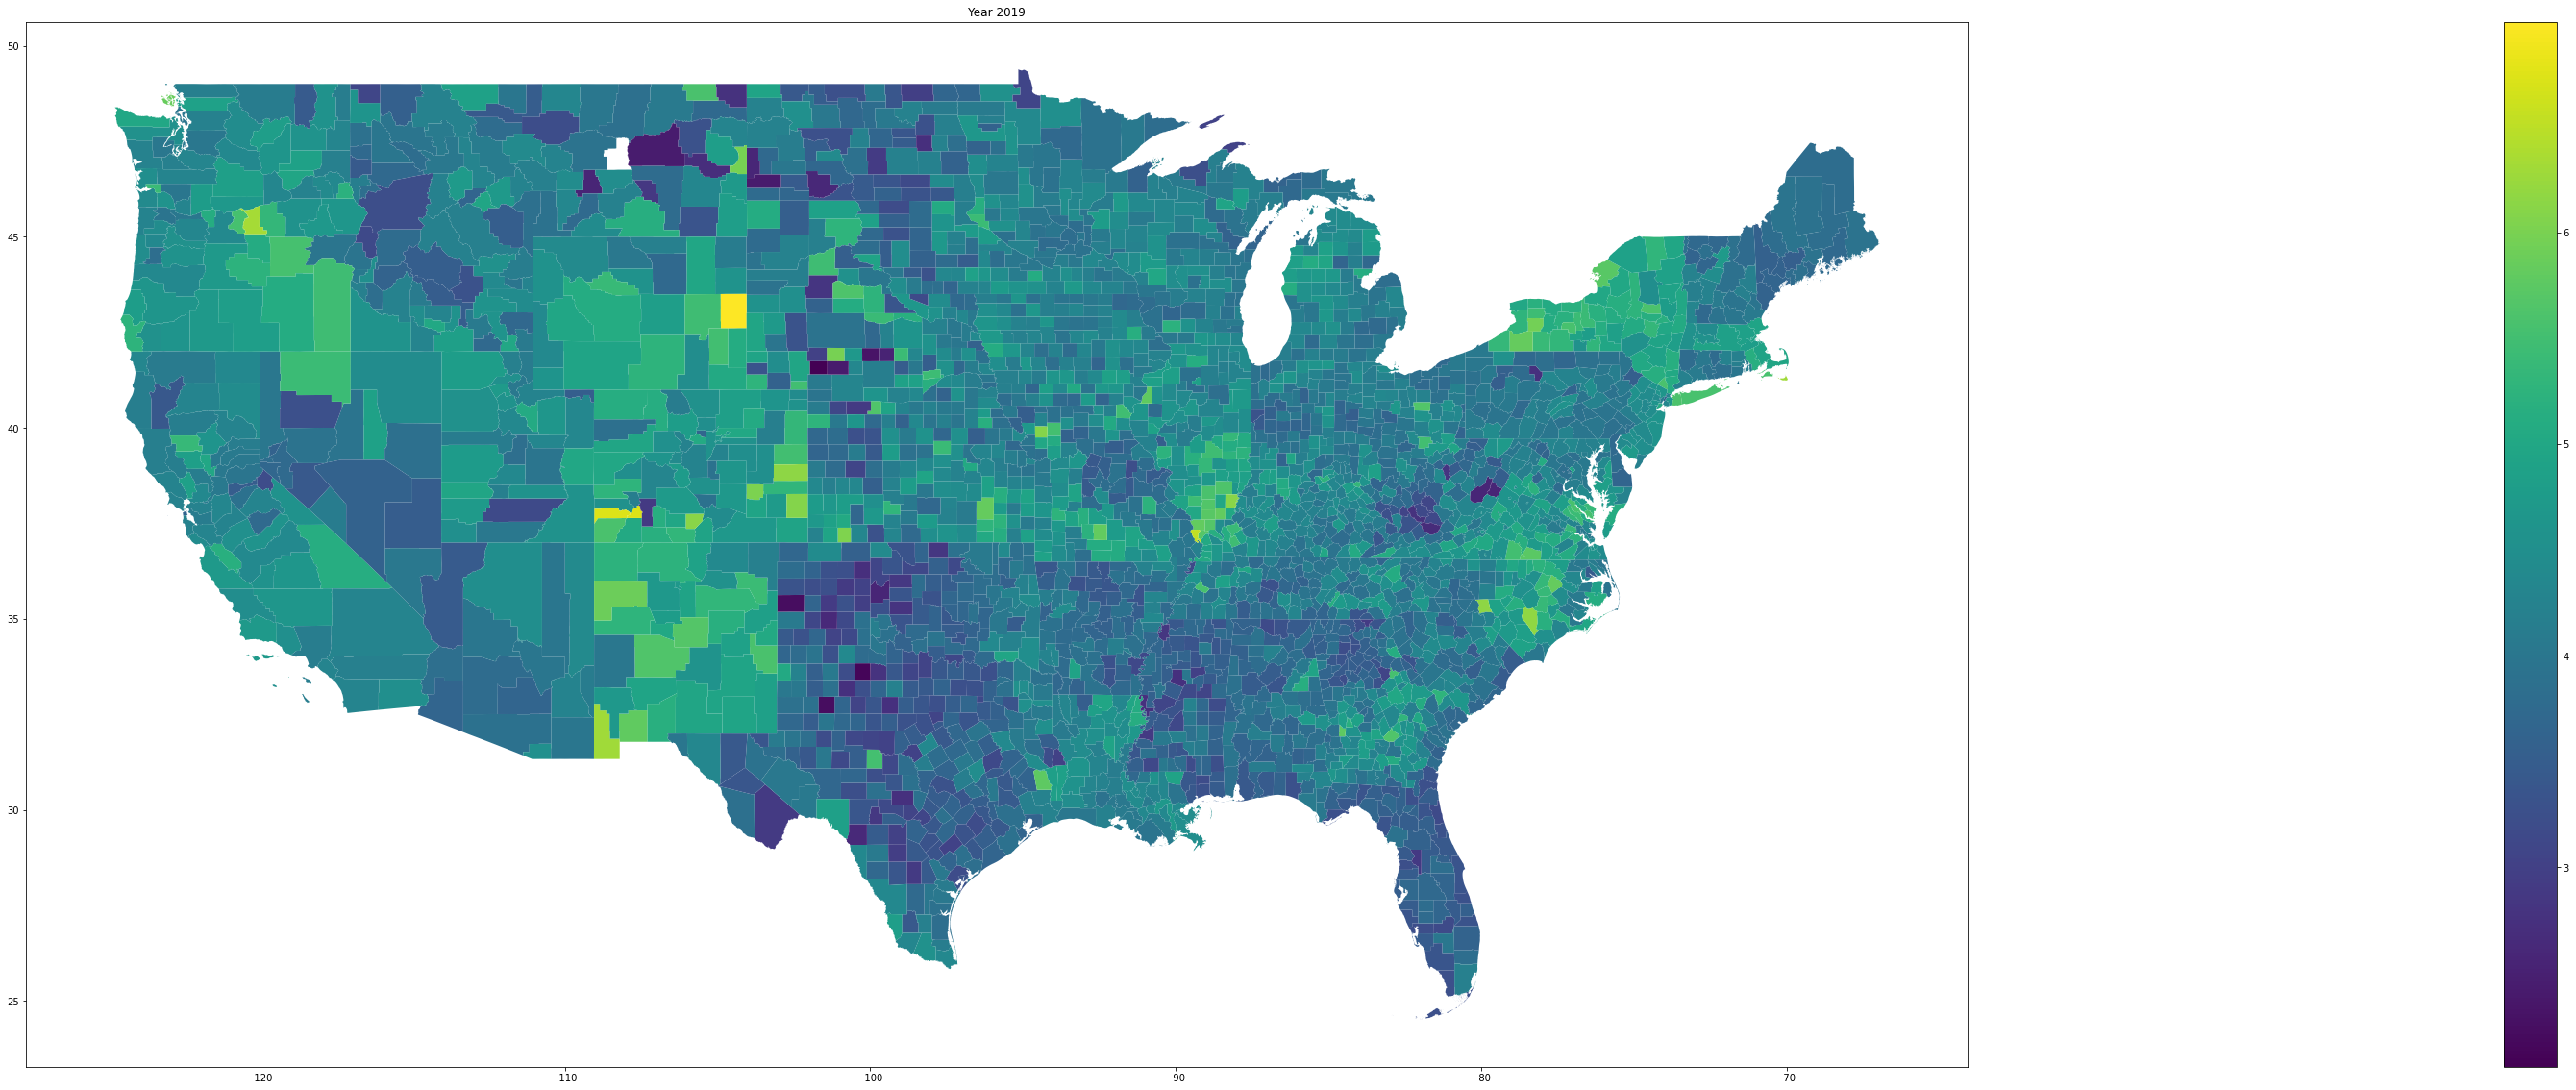

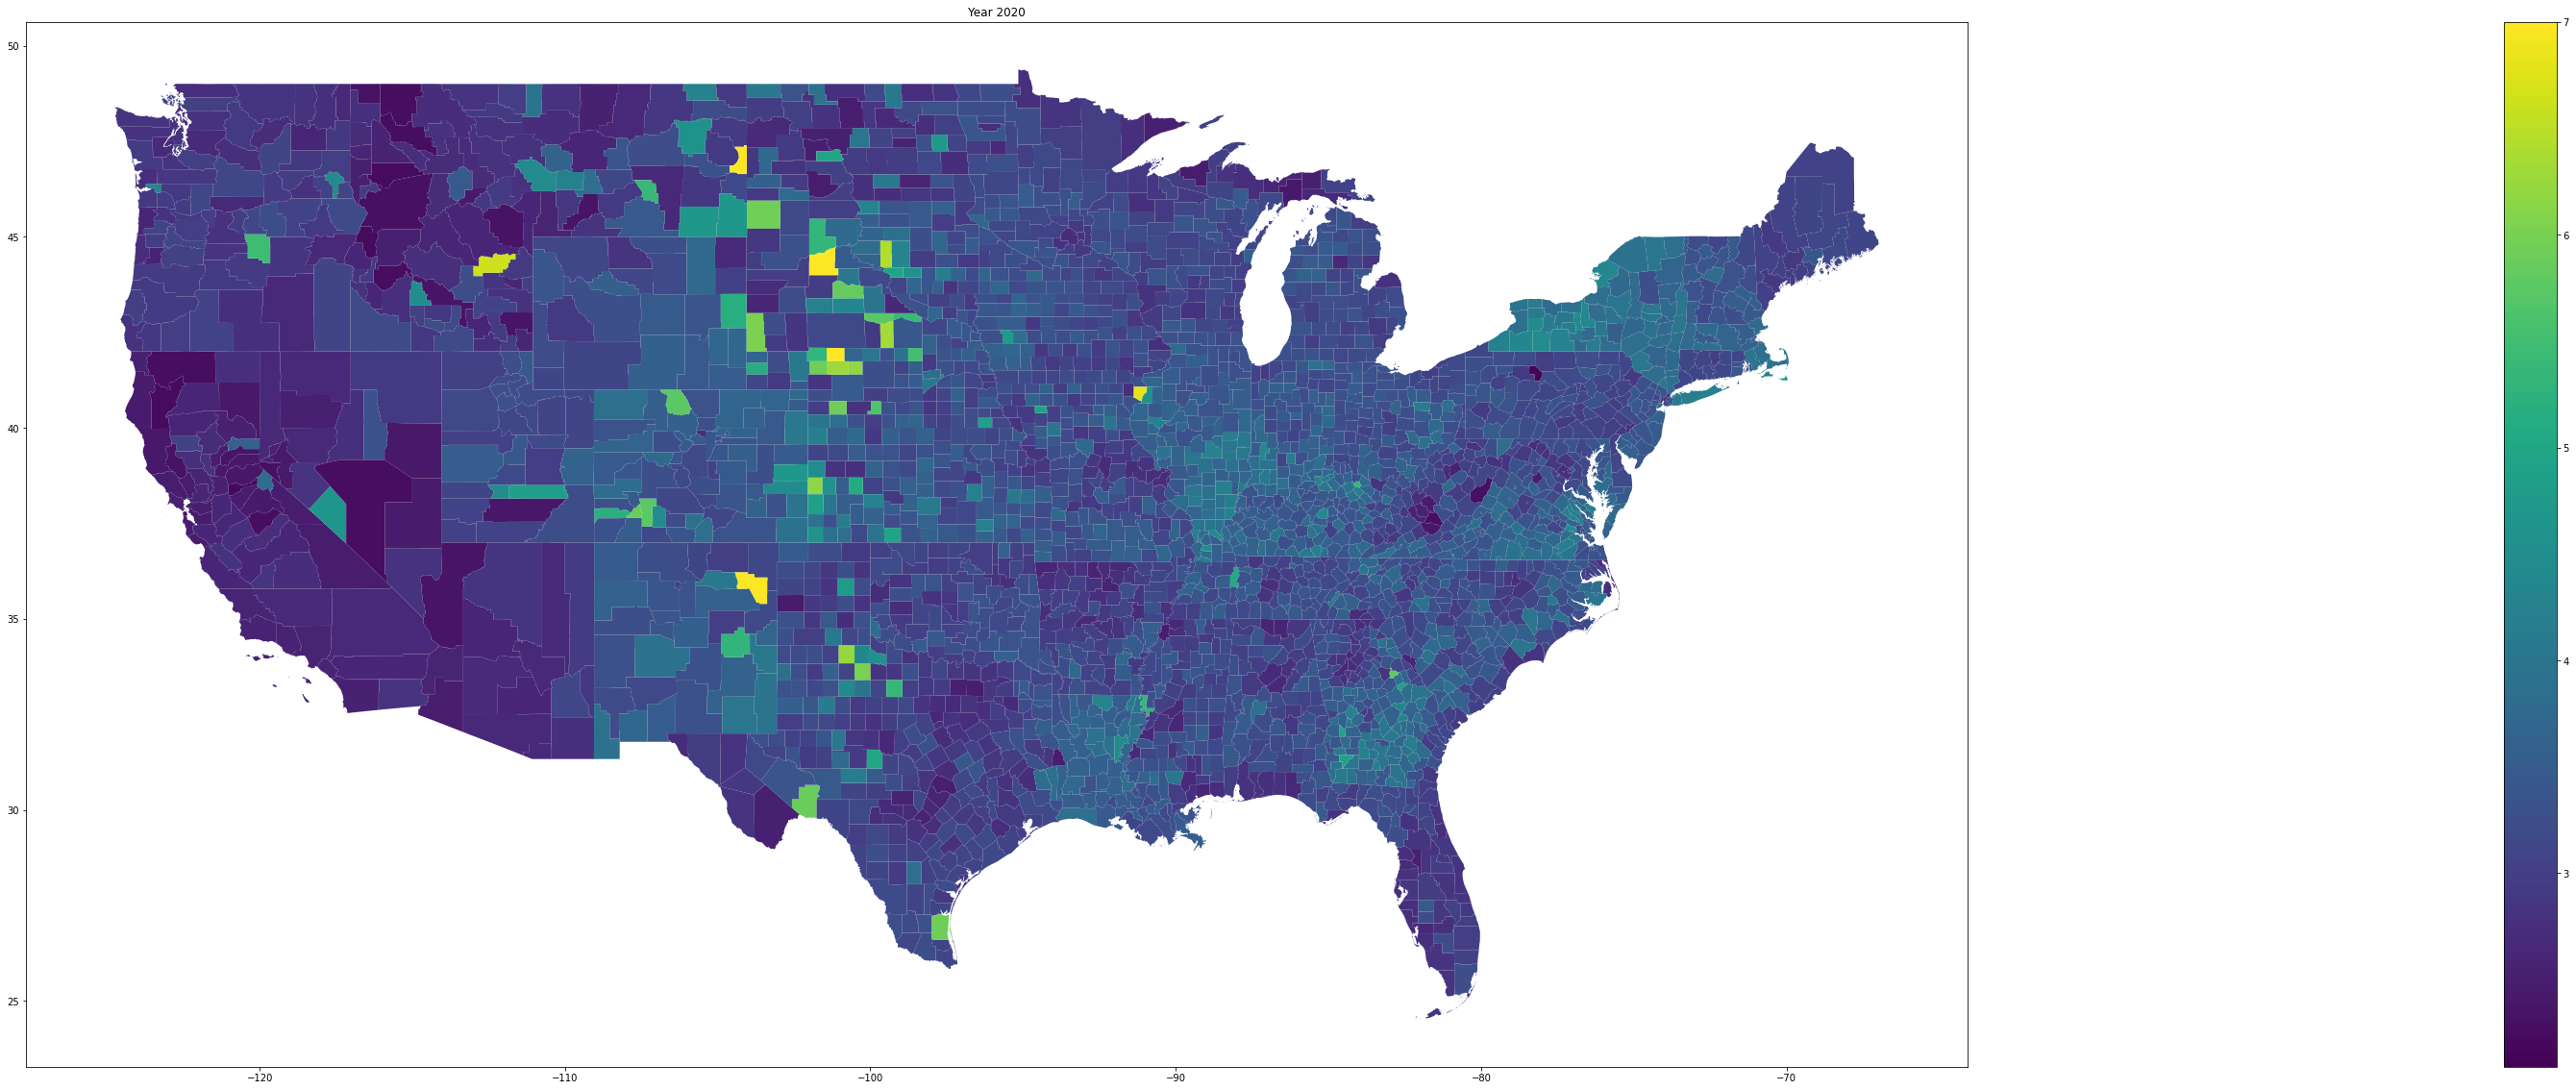

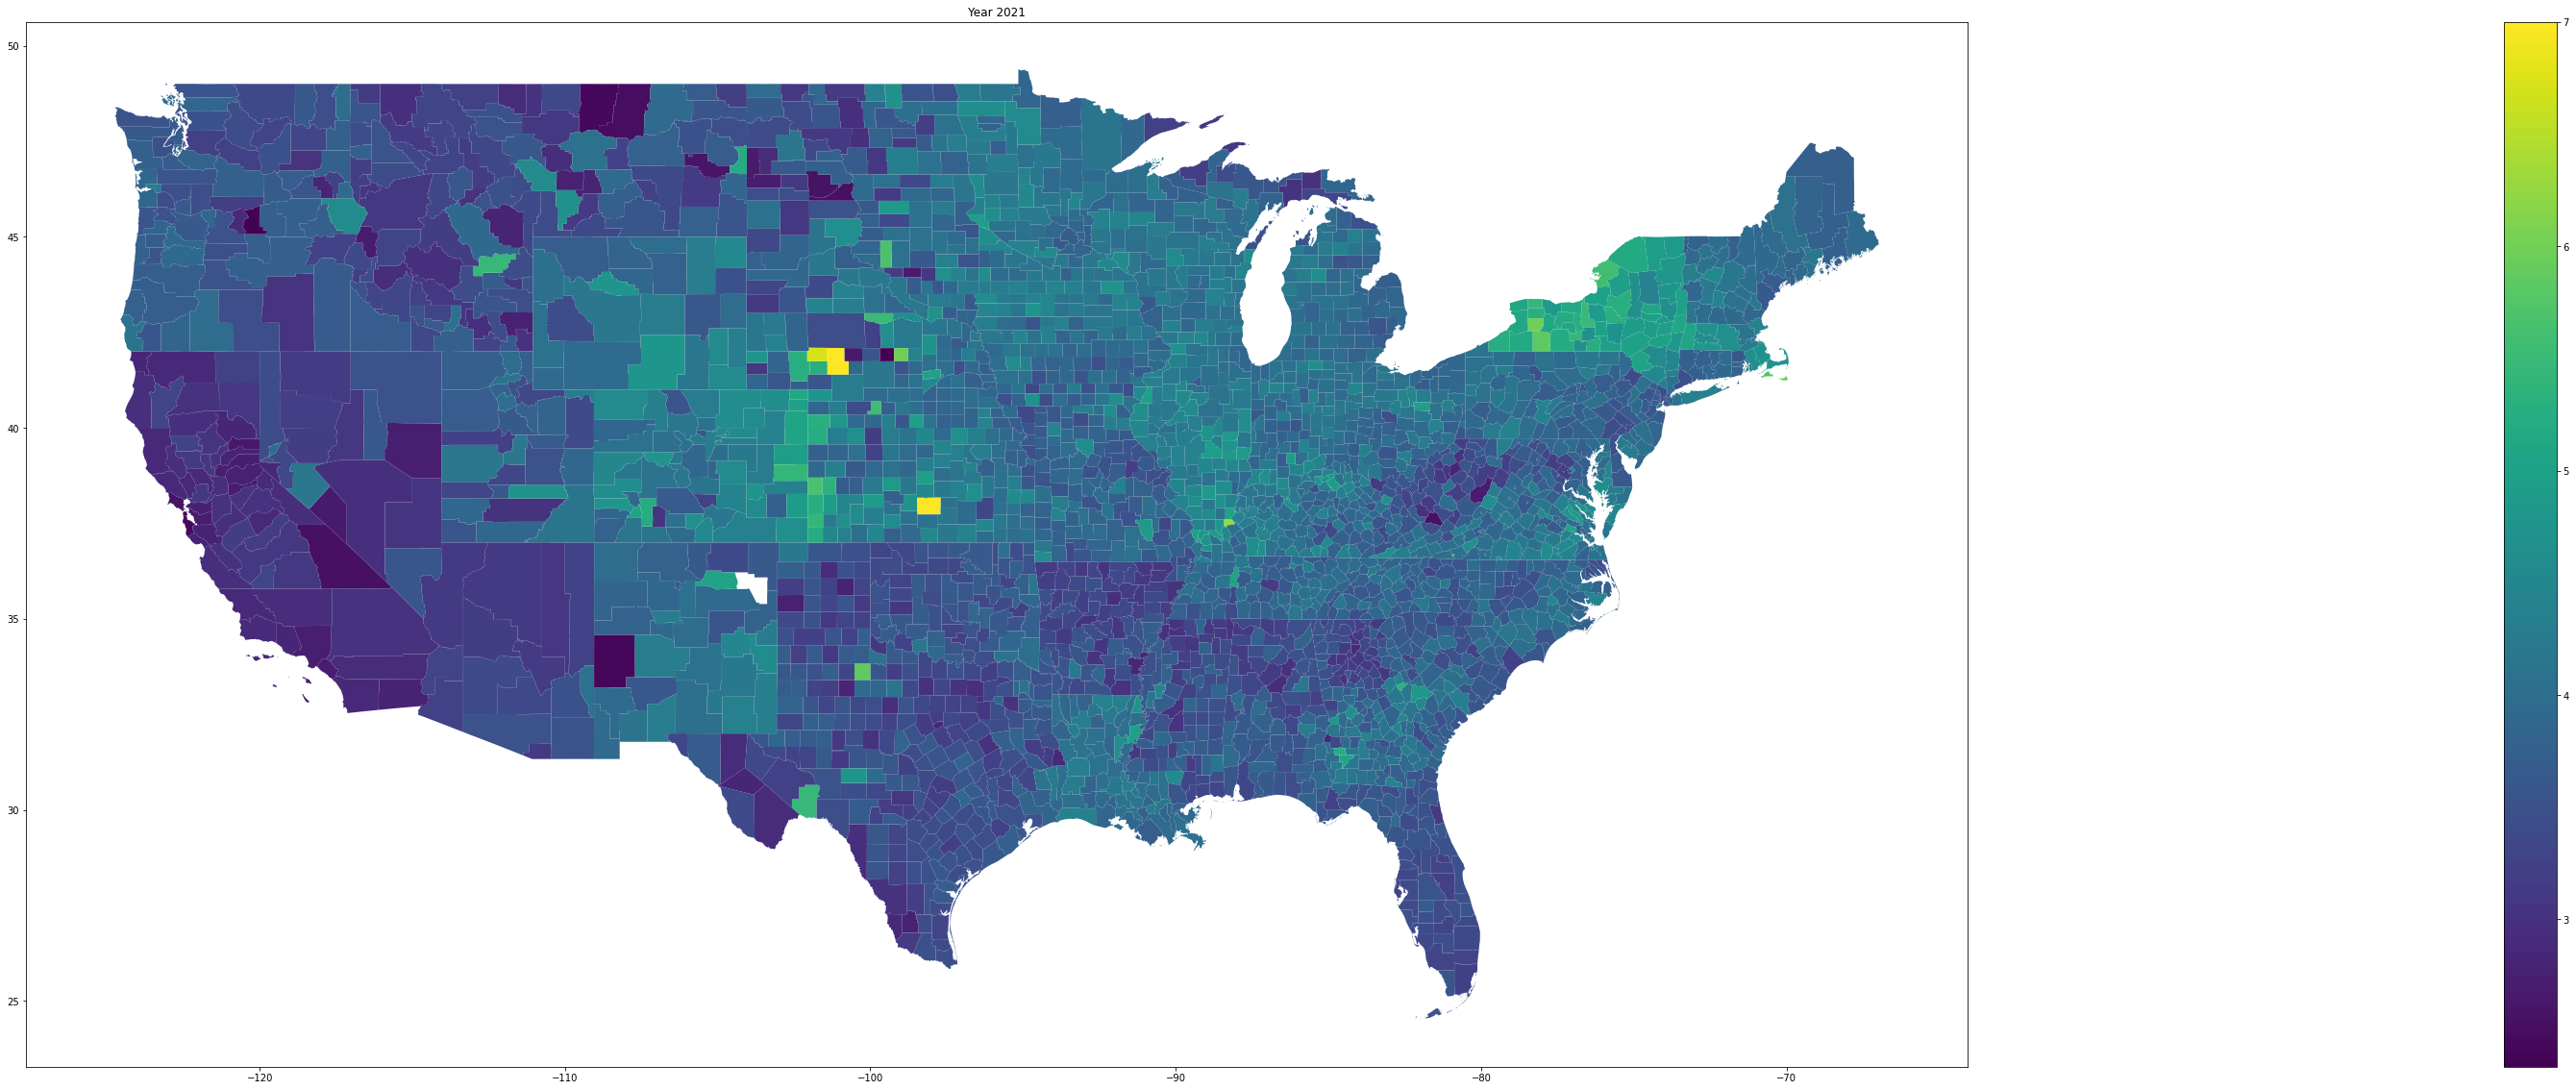

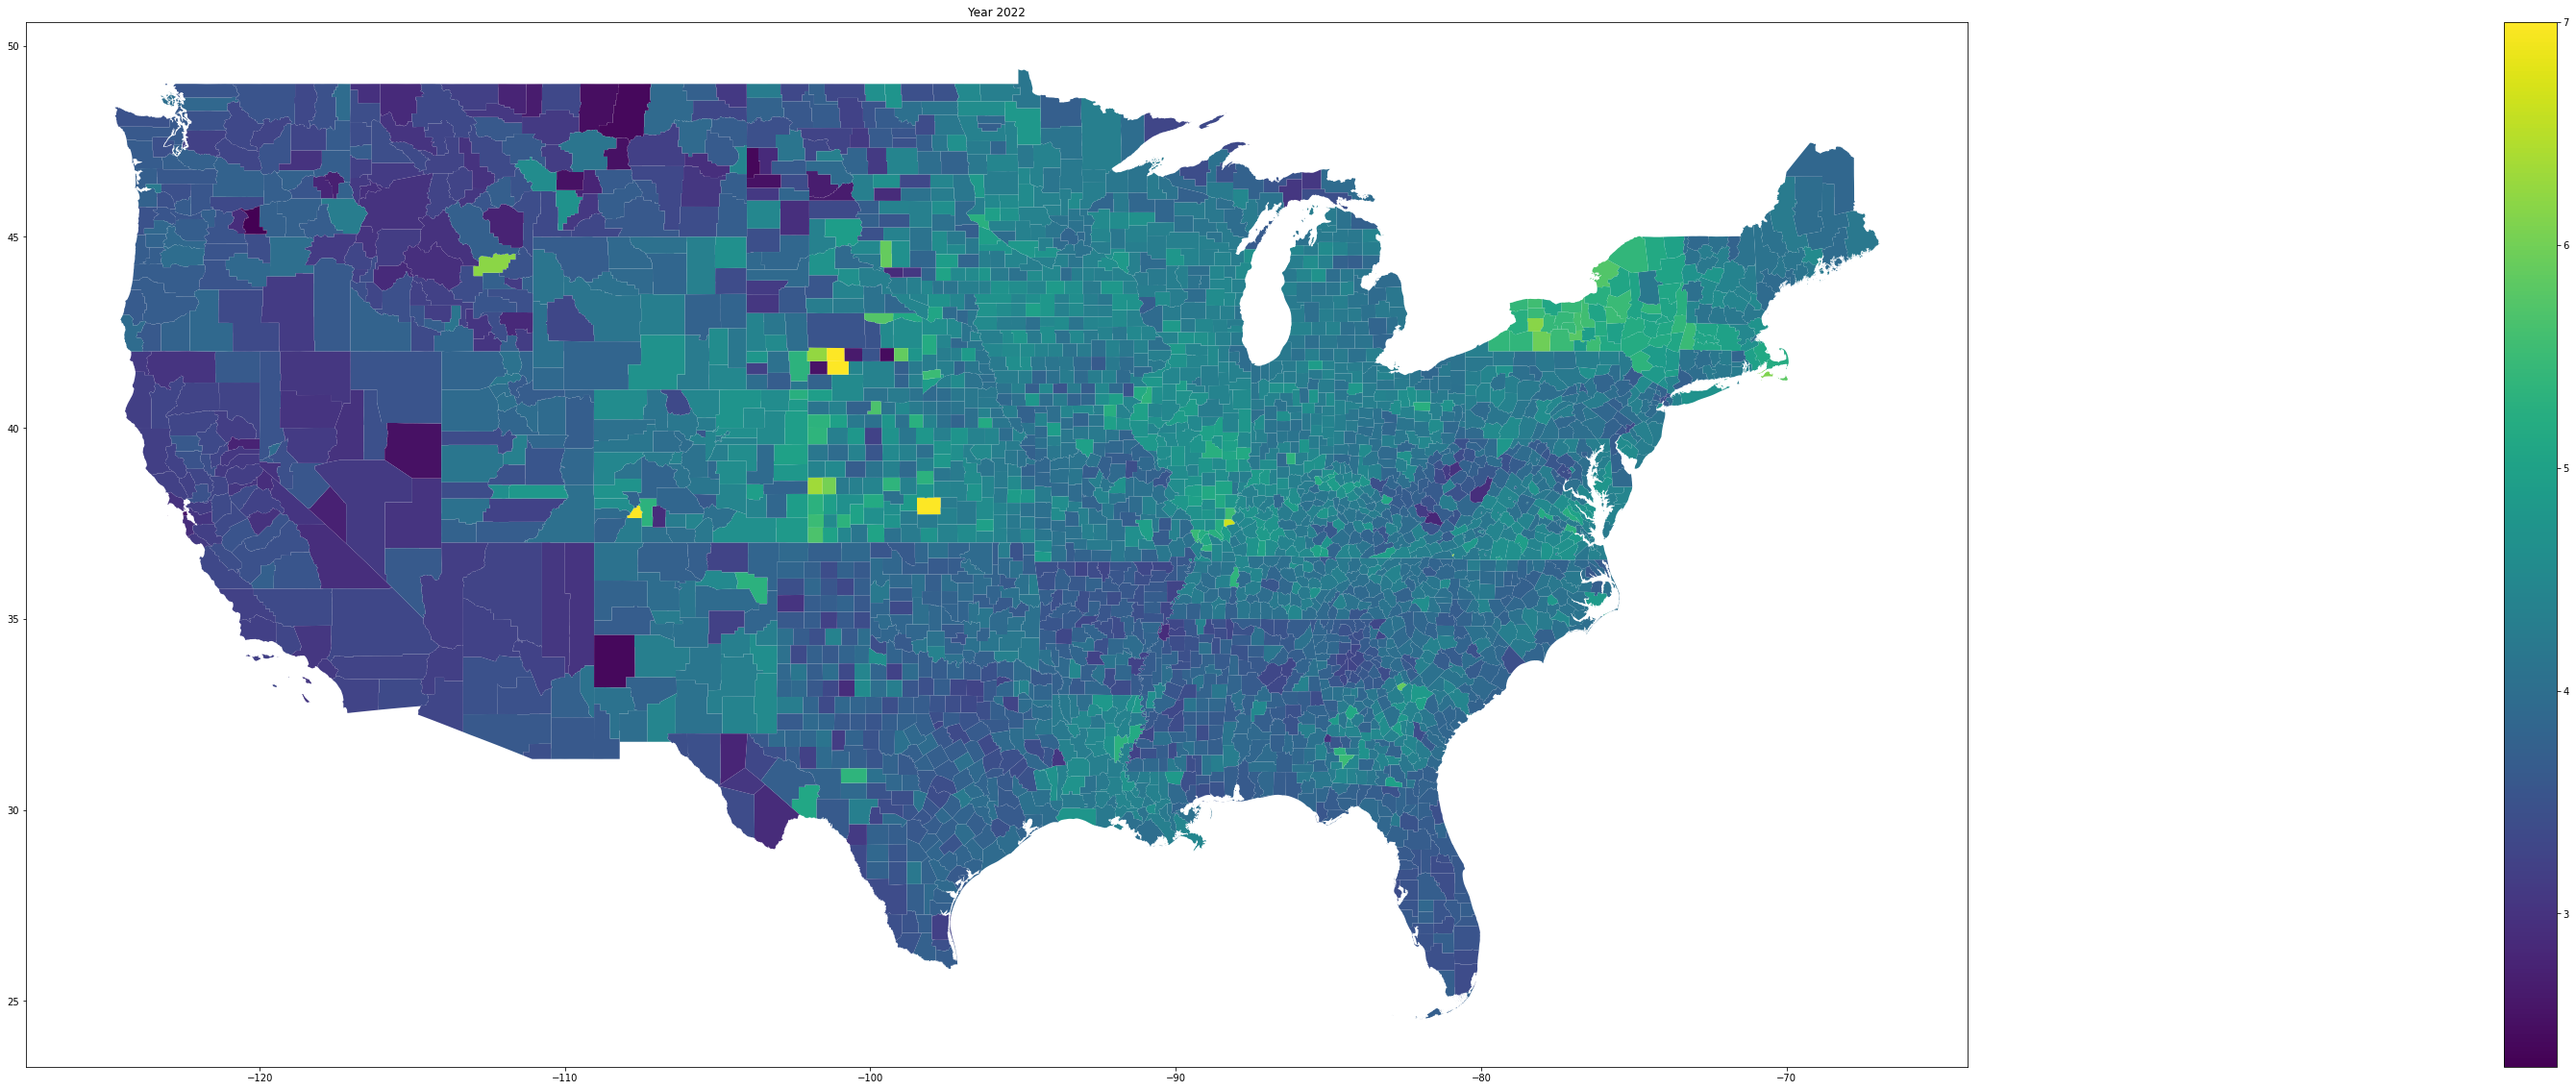

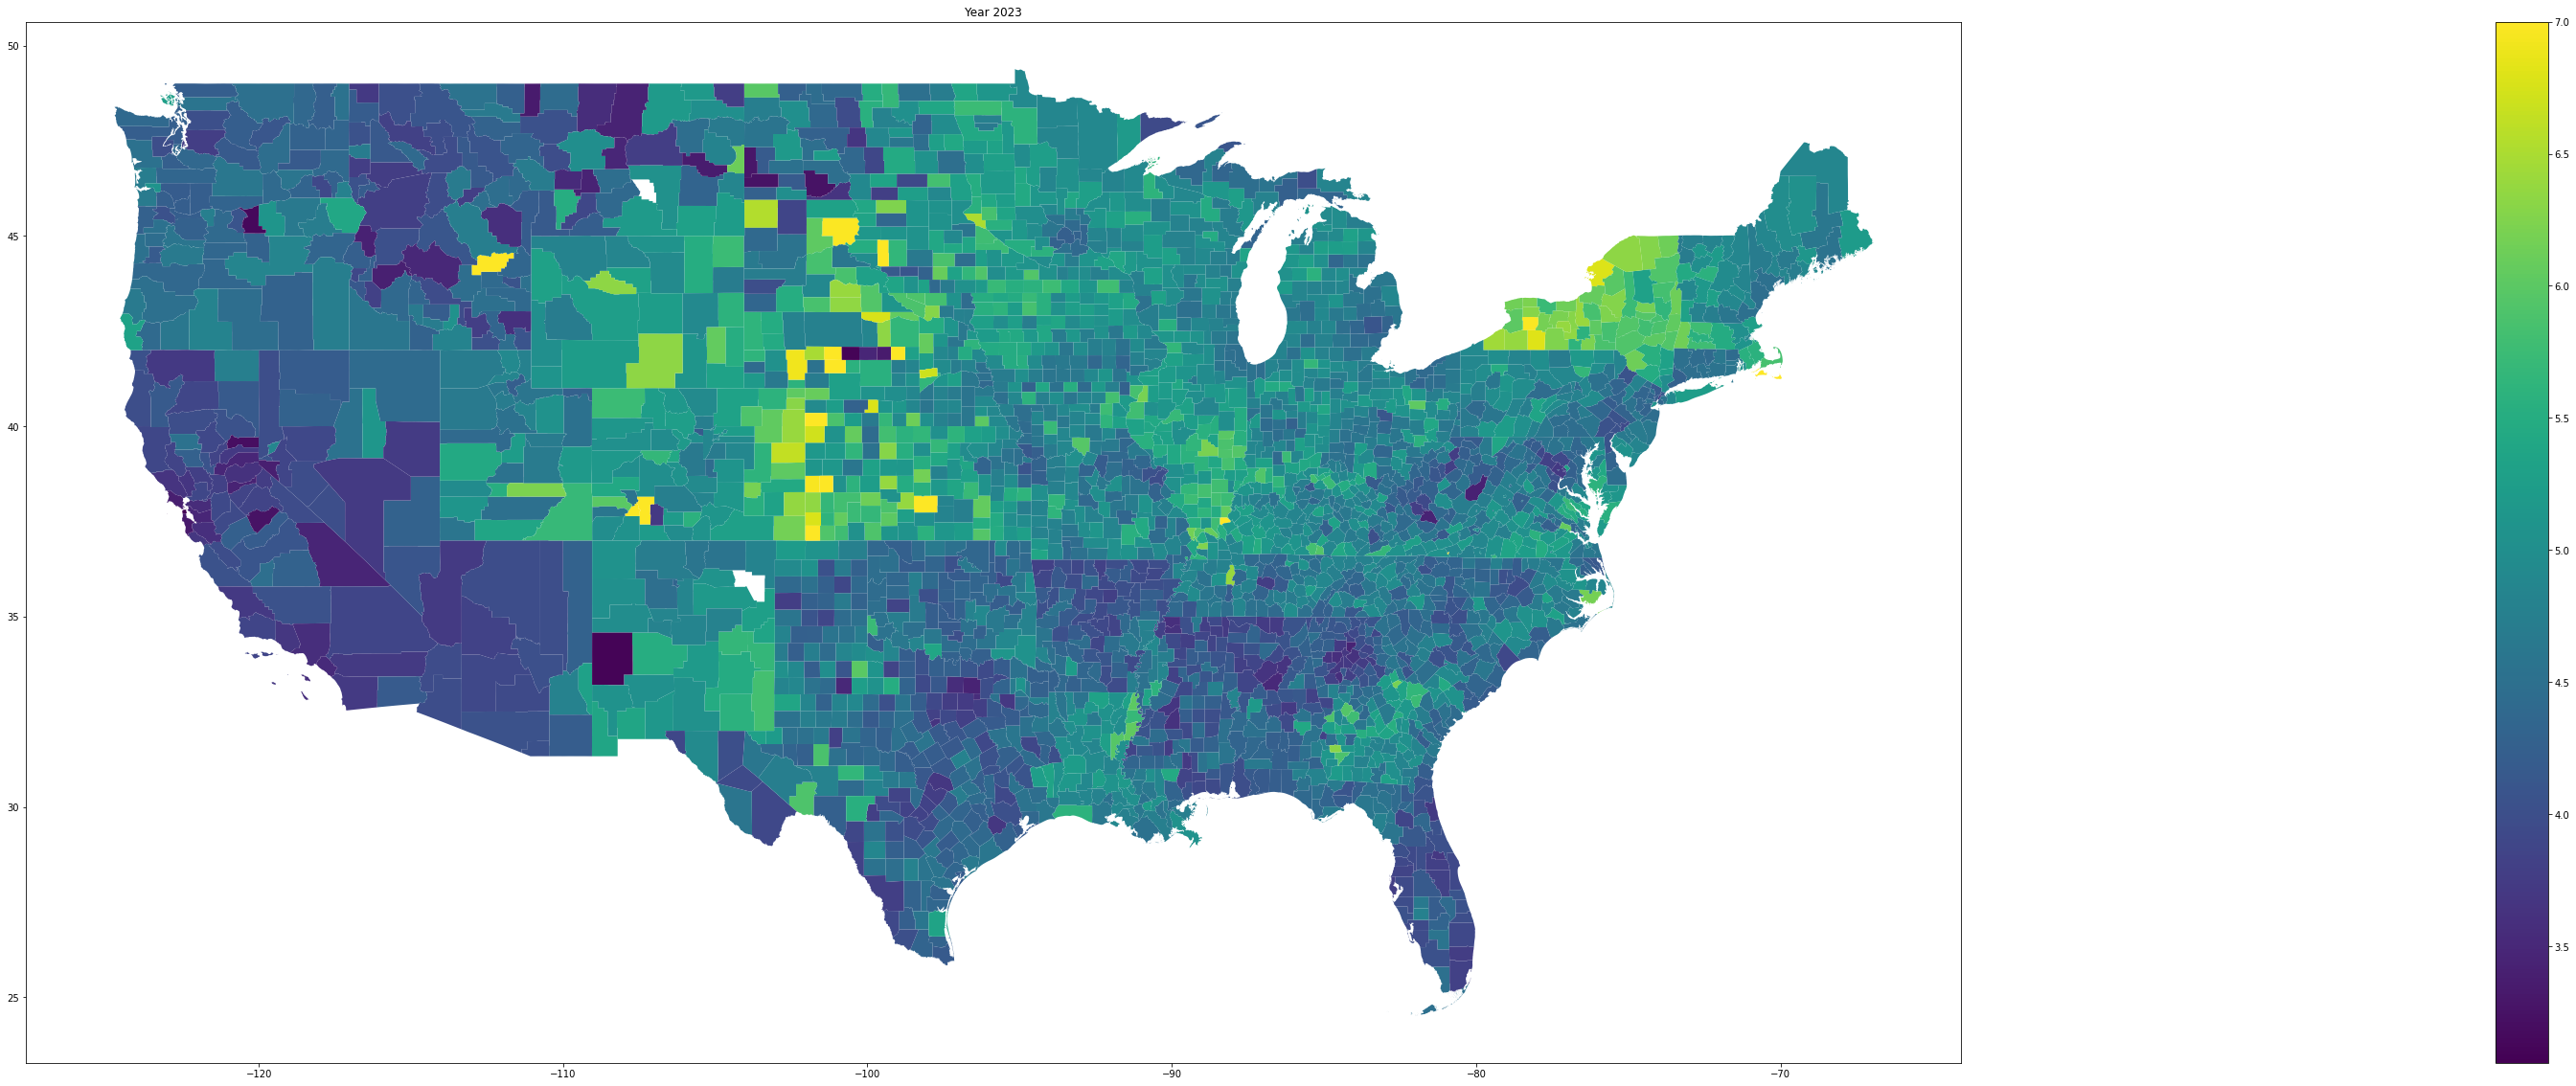

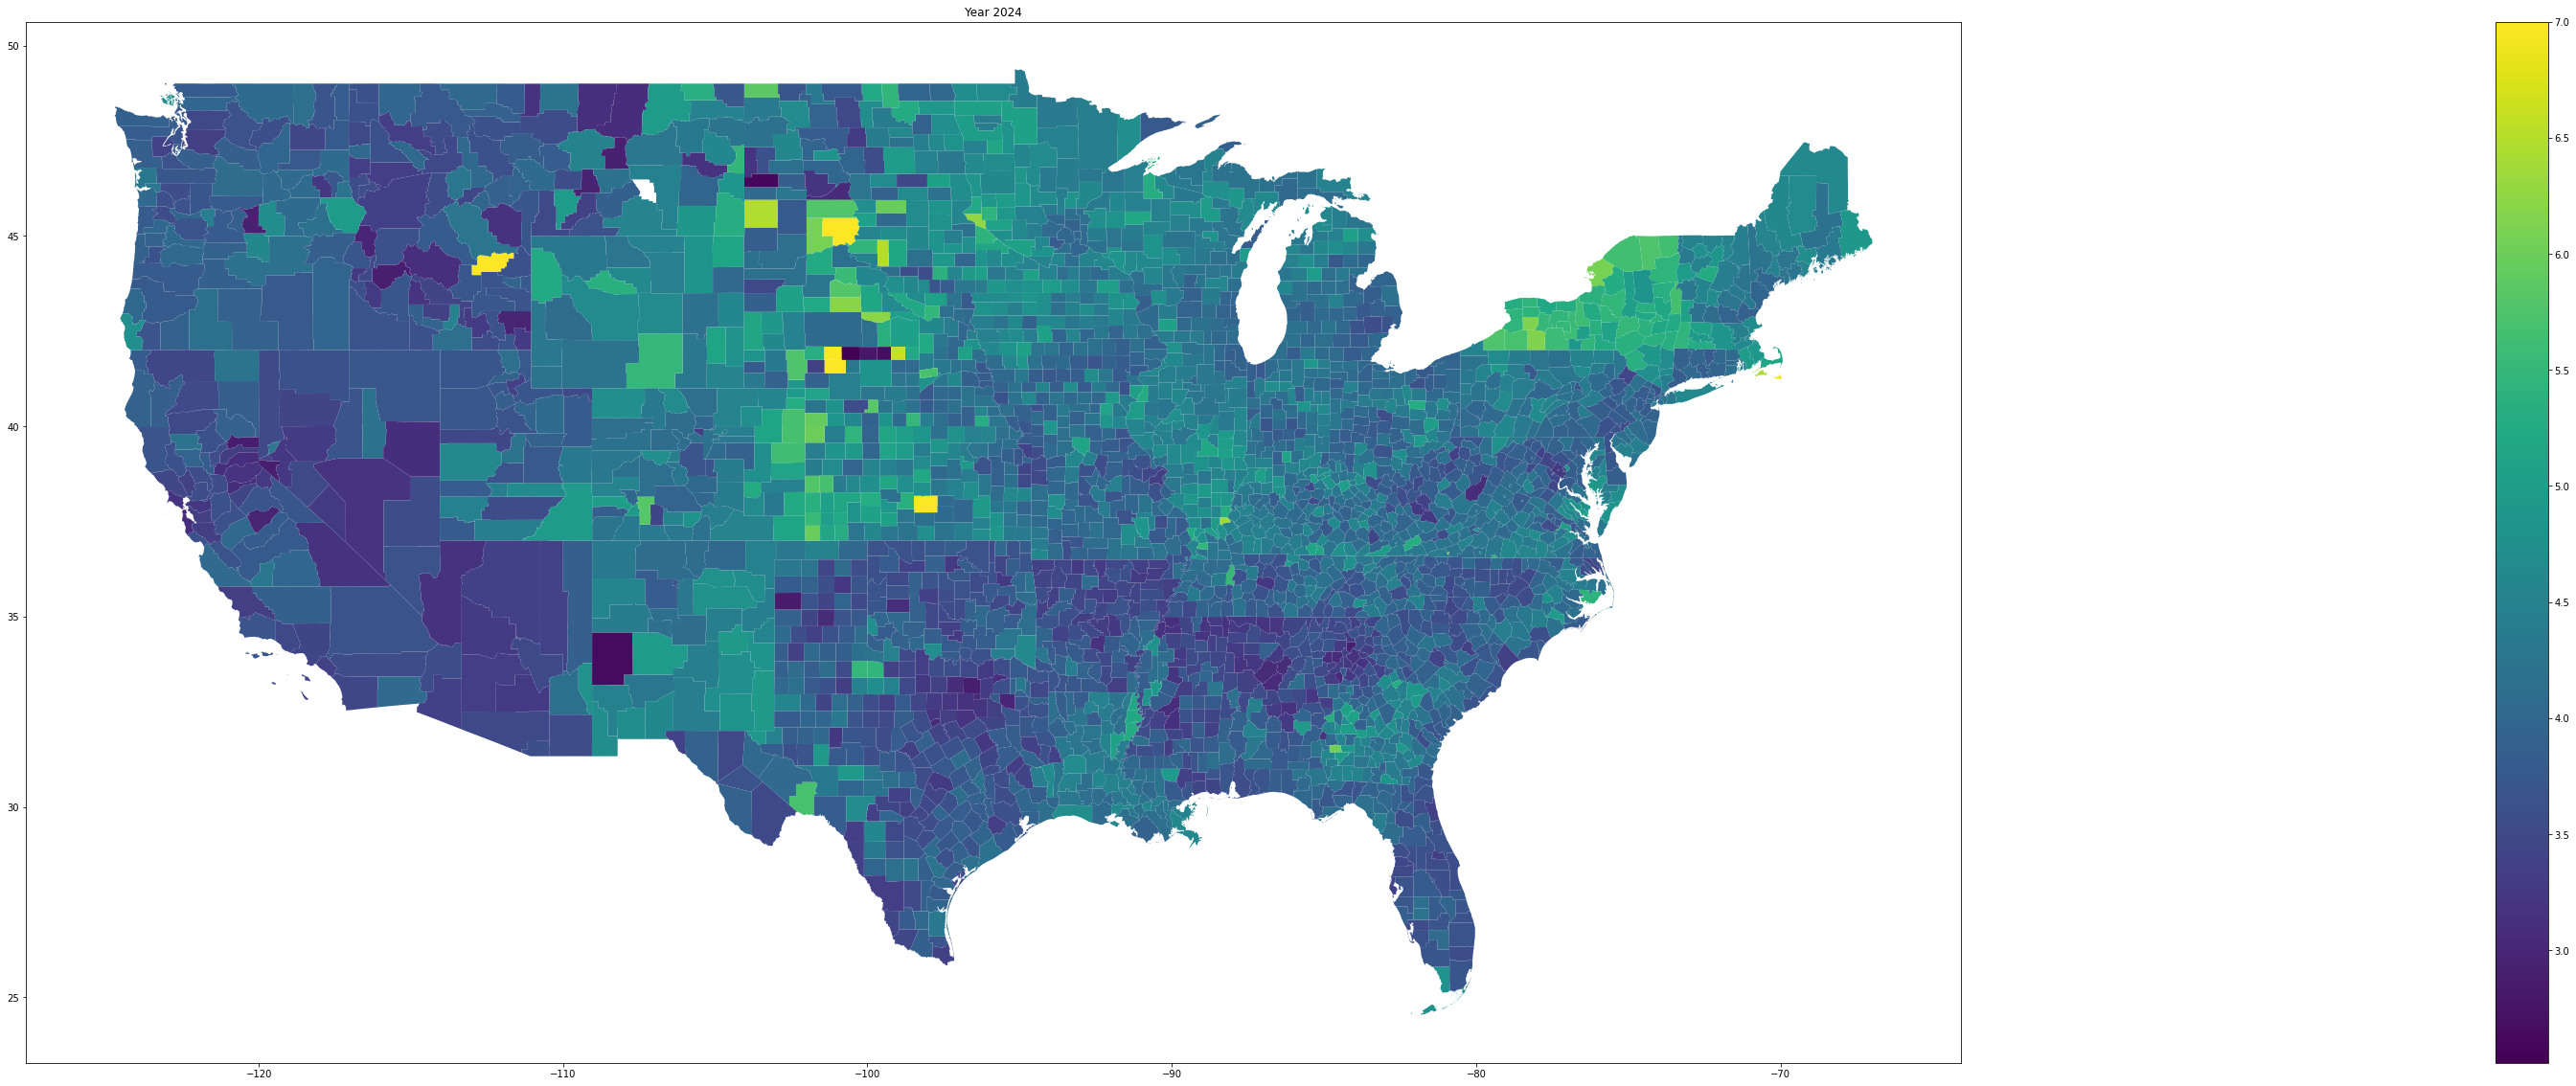

In [6]:
# Remove the counties associated with AK (02) & HI (15) for ease of viewing
complete = complete[(complete["STATE"] != "02") & (complete["STATE"] != "15")]
# Generate graph for each year for the contiguous US
for year in complete["Year"].unique():
    contiguous = complete[complete["Year"] == year].copy()
    contiguous["Per Capita"] = contiguous["Per Capita"].clip(upper=7)
    fig, ax = plt.subplots(figsize = (200,20))
    contiguous.plot(column = "Per Capita", ax = ax, legend=True)
    ax.set_title(f'Year {year}')
